In [15]:
import json
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [16]:
# with open("./output_files/couples_new.json") as json_file:
#     couples = json.load(json_file)

# with open("./output_files/compare/Melan.A/che_phy.json") as json_file:
#     couples_by_che = json.load(json_file)

# with open("./output_files/compare/Melan.A/leve.json") as json_file:
#     couples_by_lev = json.load(json_file)

with open("./output_files/tests/cdr3/test_full.json") as json_file:
    couples = json.load(json_file)

# couples = couples_by_che

In [17]:
max_neig = 1
# Create a graph
G = nx.Graph()

# Add edges to the graph based on the dictionary
for node, neighbors in couples.items():
    count = 0
    for neighbor, weight in neighbors:
        if count < max_neig:
            G.add_edge(node, neighbor, weight=weight)
            count += 1

In [18]:
def get_edges_colors(G):
    # color edegs according to their connection, the greener the color the stringer the connection
    # Create a colormap ranging from red to green
    cmap = plt.cm.RdYlGn_r

    # Find the maximum and minimum weights
    max_weight = max([d['weight'] for _, _, d in G.edges(data=True)])
    min_weight = min([d['weight'] for _, _, d in G.edges(data=True)])

    # Normalize the weights
    norm = mcolors.Normalize(vmin=min_weight, vmax=max_weight)

    # Create a color mapping based on edge weights
    edge_colors = [cmap(norm(d['weight'])) for _, _, d in G.edges(data=True)]
    return edge_colors
    

### Visualize the whole graph

### Highest degree node

/tmp/ipykernel_4177713/1523384456.py:17: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(H, pos, edge_color=edge_colors, width=2)


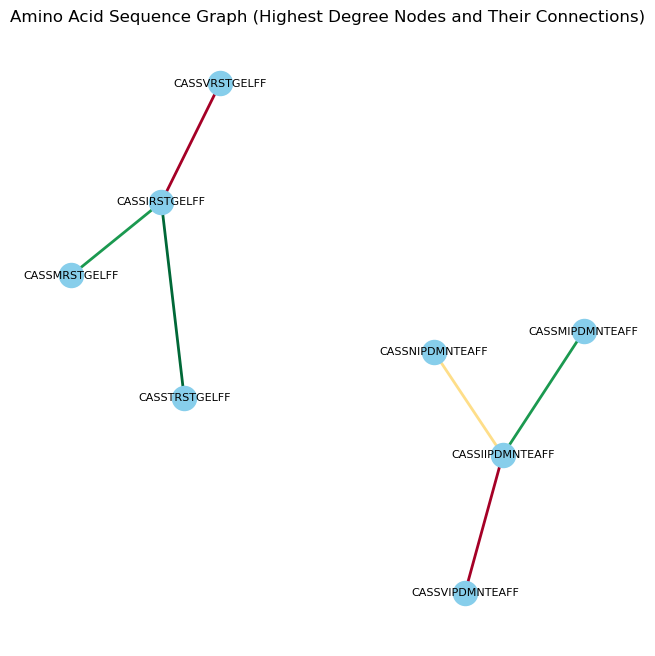

In [19]:
max_degree = max(dict(G.degree()).values())
highest_degree_nodes = [node for node, degree in dict(G.degree()).items() if degree == max_degree]

# Create a subgraph with only the highest degree nodes and their neighbors
highest_degree_neighbors = set()
for node in highest_degree_nodes:
    highest_degree_neighbors.update(G.neighbors(node))
highest_degree_neighbors.update(highest_degree_nodes)
H = G.subgraph(highest_degree_neighbors)

edge_colors = get_edges_colors(H)

# Visualize the graph
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(H, k=0.3, iterations=20)
nx.draw_networkx_nodes(H, pos, node_size=300, node_color='skyblue')
nx.draw_networkx_edges(H, pos, edge_color=edge_colors, width=2)
nx.draw_networkx_labels(H, pos, font_size=8)

# # Draw edge labels with three numbers after the decimal point
# edge_labels = {(u, v): f"{d['weight']:.3f}" for u, v, d in H.edges(data=True)}
# nx.draw_networkx_edge_labels(H, pos, edge_labels=edge_labels, font_color='black')

plt.title('Amino Acid Sequence Graph (Highest Degree Nodes and Their Connections)')
plt.axis('off')  # Turn off axis
plt.savefig('degree.png')
plt.show()


### Longest path

/tmp/ipykernel_4177713/1656020794.py:17: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(H, pos, edge_color=edge_colors, width=2)


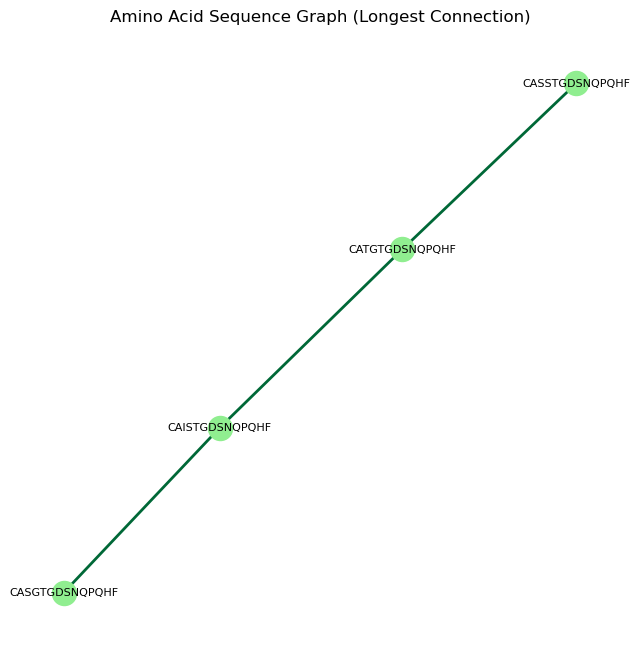

In [20]:
# Find the longest path in the graph
longest_path = max(nx.all_pairs_shortest_path_length(G), key=lambda x: max(x[1].values()))

# Extract nodes involved in the longest path
longest_path_nodes = longest_path[1].keys()

# Create a subgraph with nodes involved in the longest path
H = G.subgraph(longest_path_nodes)

edge_colors = get_edges_colors(H)


# Visualize the graph
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(H, k=0.3, iterations=20)
nx.draw_networkx_nodes(H, pos, node_size=300, node_color='lightgreen')
nx.draw_networkx_edges(H, pos, edge_color=edge_colors, width=2)
nx.draw_networkx_labels(H, pos, font_size=8)

# # Draw edge labels with three numbers after the decimal point
# edge_labels = {(u, v): f"{d['weight']:.3f}" for u, v, d in H.edges(data=True)}
# nx.draw_networkx_edge_labels(H, pos, edge_labels=edge_labels, font_color='black')


plt.title('Amino Acid Sequence Graph (Longest Connection)')
plt.axis('off')  # Turn off axis
plt.savefig('longest_path.png')
plt.show()

### Strongest Connection

### Biggest Cluster

/tmp/ipykernel_4177713/2796849716.py:22: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(H, pos, edge_color=edge_colors, width=2)


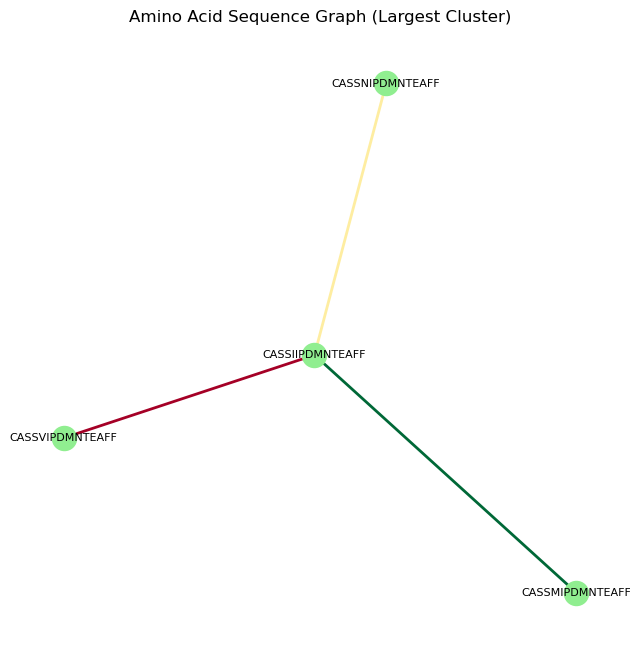

In [21]:

# Find all connected components
connected_components = list(nx.connected_components(G))

# Find the largest connected component
largest_component = max(connected_components, key=len)

# Find nth largest connected component
n = 2
largest_component = sorted(nx.connected_components(G), key=len, reverse=True)[n-1]



# Create a subgraph with nodes in the largest connected component
H = G.subgraph(largest_component)

edge_colors = get_edges_colors(H)

# Visualize the largest cluster
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(H, k=0.3, iterations=20)
nx.draw_networkx_nodes(H, pos, node_size=300, node_color='lightgreen')
nx.draw_networkx_edges(H, pos, edge_color=edge_colors, width=2)
nx.draw_networkx_labels(H, pos, font_size=8)


plt.title('Amino Acid Sequence Graph (Largest Cluster)')
plt.axis('off')  # Turn off axis
plt.savefig('largest_cluster.png')
plt.show()


In [22]:

# Find connected components
clusters = list(nx.connected_components(G))

# Create a dictionary to map sequences to cluster numbers
cluster_dict = {}
for cluster_number, cluster in enumerate(clusters):
    for sequence in cluster:
        cluster_dict[sequence] = cluster_number

# Print the cluster dictionary
cluster_dict

{'CASSVRSTDTQYF': 0,
 'CASSIRSEDTQYF': 0,
 'CASSIRSTDTQYF': 0,
 'CASSWGQGKSSYEQYF': 1,
 'CASSLGQGKSSYEQYF': 1,
 'CASSIGQGKSSYEQYF': 1,
 'CASSWSFGTEAFF': 2,
 'CASSLSFGTEAFF': 2,
 'CSVGSGGTNEKLFF': 3,
 'CSVGTGGTNEKLFF': 3,
 'CASSSRAAYEQYF': 4,
 'CASSSRSSYEQYF': 4,
 'CASSSRASYEQYF': 4,
 'CASSQGSYEQYF': 5,
 'CASSYGSYEQYF': 5,
 'CASSTGNYGYTF': 6,
 'CASSTGFYGYTF': 6,
 'CASSQETQYF': 7,
 'CASSAETQYF': 7,
 'CASSLYSNQPQHF': 8,
 'CASSQYSNQPQHF': 8,
 'CASSYLGNTGELFF': 9,
 'CASSYVGNTGELFF': 9,
 'CASSIRSTGELFF': 10,
 'CASSMRSTGELFF': 10,
 'CASSVRSTGELFF': 10,
 'CASSTRSTGELFF': 10,
 'CASSSAYYGYTF': 11,
 'CASSSAFYGYTF': 11,
 'CASSSANYGYTF': 11,
 'CASSVEGGGAKETQYF': 12,
 'CASSVEGGGAQETQYF': 12,
 'CASSVIPDMNTEAFF': 13,
 'CASSNIPDMNTEAFF': 13,
 'CASSIIPDMNTEAFF': 13,
 'CASSMIPDMNTEAFF': 13,
 'CASSFQGYTEAFF': 14,
 'CASSFQGFTEAFF': 14,
 'CASSNVPDMNTEAFF': 15,
 'CASSMVPDMNTEAFF': 15,
 'CASSSGQAYEQYF': 16,
 'CASSLGQAYEQYF': 16,
 'CASSLDSSGGNEQYF': 17,
 'CASSLDSSSGNTIYF': 17,
 'CAWSETGLGTGELFF': 18,
 'CAWSETG

In [ ]:
import pandas as pd

df = pd.read_csv("output_files/tests/cdr3/predicted clusters.csv")


In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# Assuming your table is in a pandas DataFrame called 'df'
# and the columns are 'epitope.antigen' (actual) and 'epitope.ped' (predicted)

# Calculate accuracy
accuracy = accuracy_score(df['epitope.antigen'], df['epitope.ped'])

# Calculate precision
precision = precision_score(df['epitope.antigen'], df['epitope.ped'], average='weighted')

# Calculate recall
recall = recall_score(df['epitope.antigen'], df['epitope.ped'], average='weighted')

# Create a confusion matrix
conf_matrix = confusion_matrix(df['epitope.antigen'], df['epitope.ped'])

# Display results
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print("Confusion Matrix:")
print(conf_matrix)


In [23]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score

df = pd.read_csv("output_files/tests/cdr3/predicted clusters.csv")


# Ensure that the columns are converted to strings
df['antigen.epitope'] = df['antigen.epitope'].astype(str)
df['epitope.pred'] = df['epitope.pred'].astype(str)

# Calculate accuracy
accuracy = accuracy_score(df['antigen.epitope'], df['epitope.pred'])

# Calculate precision
precision = precision_score(df['antigen.epitope'], df['epitope.pred'], average='weighted', zero_division=1)

# Calculate recall
recall = recall_score(df['antigen.epitope'], df['epitope.pred'], average='weighted', zero_division=1)

# Print the results
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')


Accuracy: 0.12988826815642457
Precision: 0.9746907422186751
Recall: 0.12988826815642457
